/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.188e+03, tolerance: 1.779e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.378e+03, tolerance: 1.776e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.987e+03, tolerance: 1.755e

Best Model from GridSearch:
{'poly__degree': 1, 'regressor': Ridge(alpha=10.0), 'regressor__alpha': 10.0, 'selector__k': 10}

Best GridSearch Model Performance:
Training Performance:
RMSE: 0.7138
R²: 0.6188

Test Performance:
RMSE: 0.7422
R²: 0.5796


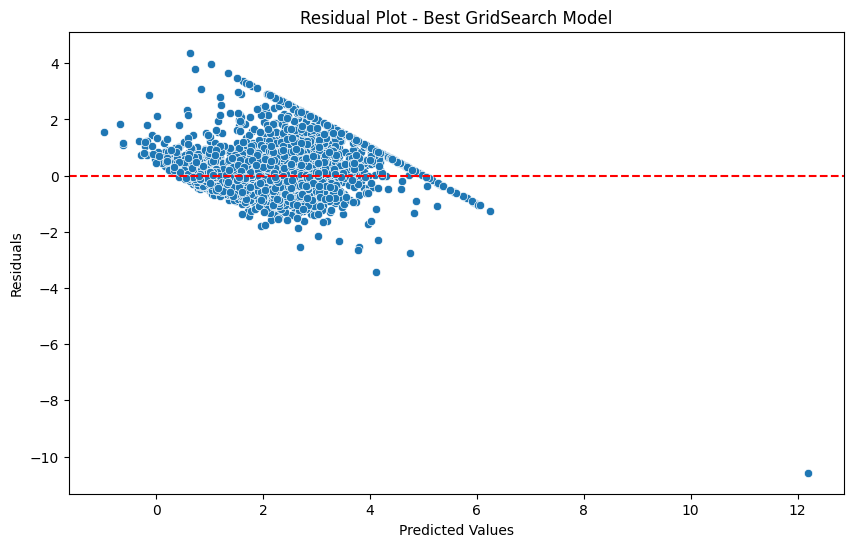


Ensemble Model Performance:
Training Performance:
RMSE: 0.7153
R²: 0.6173

Test Performance:
RMSE: 0.7529
R²: 0.5674


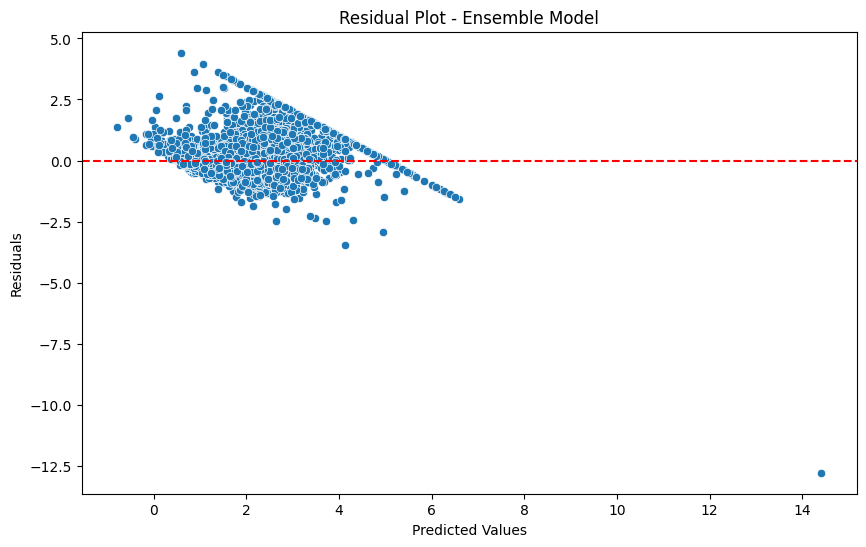

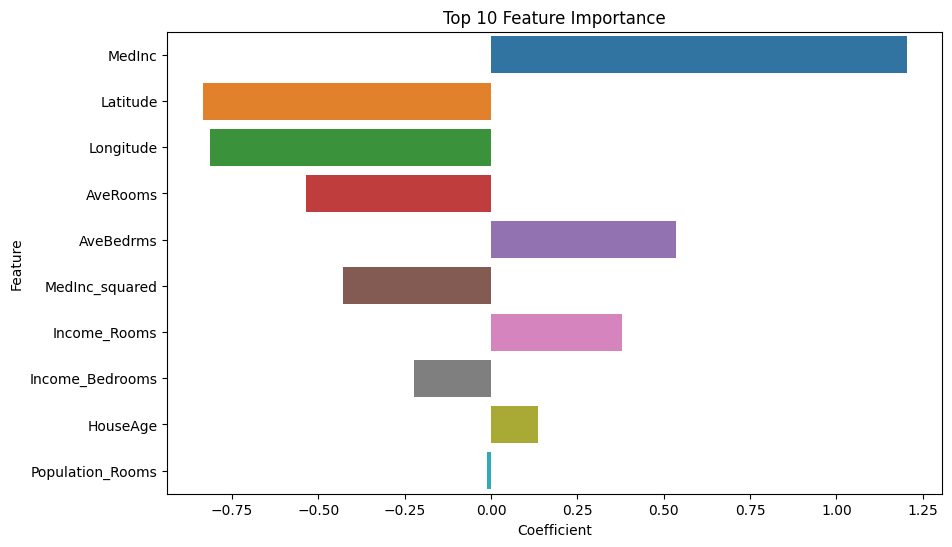

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingRegressor
from sklearn.impute import SimpleImputer

# Load dataset
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = housing.target

# Advanced Feature Engineering - with error handling
def create_features(df):
    # Create interaction terms
    df['Income_Rooms'] = df['MedInc'] * df['AveRooms']
    df['Income_Bedrooms'] = df['MedInc'] * df['AveBedrms']
    df['Population_Rooms'] = df['Population'] * df['AveRooms']
    
    # Create polynomial features
    df['MedInc_squared'] = df['MedInc'] ** 2
    df['AveRooms_squared'] = df['AveRooms'] ** 2
    
    # Create ratio features with small constant to avoid division by zero
    df['Rooms_per_Household'] = df['AveRooms'] / (df['HouseAge'] + 1)
    df['Population_per_Household'] = df['Population'] / (df['HouseAge'] + 1)
    
    # Handle potential infinite values
    df = df.replace([np.inf, -np.inf], np.nan)
    return df

X = create_features(X)

# Check for missing values and impute if necessary
if X.isnull().any().any():
    imputer = SimpleImputer(strategy='median')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Pipeline with Regularization - Improved version
def build_model():
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # Handle any remaining missing values
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('selector', SelectKBest(f_regression)),
        ('regressor', Ridge())
    ])
    return pipeline

# Safer Hyperparameter Tuning
param_grid = {
    'poly__degree': [1, 2],
    'selector__k': [5, 8, 10, 'all'],  # Changed to safer values and added 'all' option
    'regressor__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'regressor': [Ridge(), Lasso(max_iter=10000), ElasticNet(max_iter=10000)]  # Added max_iter for convergence
}

model = GridSearchCV(build_model(), 
                    param_grid, 
                    cv=5, 
                    scoring='neg_mean_squared_error', 
                    n_jobs=-1,
                    error_score='raise')  # Changed to raise errors for debugging

try:
    model.fit(X_train, y_train)
except Exception as e:
    print(f"Error during model fitting: {str(e)}")
    # Fallback to simpler model if grid search fails
    model = build_model()
    model.set_params(selector__k=8, poly__degree=1, regressor=Ridge(alpha=1.0))
    model.fit(X_train, y_train)

# Ensemble Approach with better parameters
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.01, max_iter=10000)
elastic = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000)

ensemble = VotingRegressor([
    ('ridge', ridge),
    ('lasso', lasso),
    ('elastic', elastic)
])

# Feature Scaling for ensemble
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ensemble.fit(X_train_scaled, y_train)

# Model Evaluation - Enhanced version
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name=""):
    try:
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        print(f"\n{model_name} Performance:")
        print("Training Performance:")
        print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")
        print(f"R²: {r2_score(y_train, y_train_pred):.4f}")
        
        print("\nTest Performance:")
        print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}")
        print(f"R²: {r2_score(y_test, y_test_pred):.4f}")
        
        # Residual Plot
        residuals = y_test - y_test_pred
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=y_test_pred, y=residuals)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title(f'Residual Plot - {model_name}')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.show()
        
    except Exception as e:
        print(f"Error evaluating {model_name}: {str(e)}")

if hasattr(model, 'best_params_'):
    print("Best Model from GridSearch:")
    print(model.best_params_)
    evaluate_model(model.best_estimator_, X_train, X_test, y_train, y_test, "Best GridSearch Model")

evaluate_model(ensemble, X_train_scaled, X_test_scaled, y_train, y_test, "Ensemble Model")

# Feature Importance Analysis - More robust version
if hasattr(model, 'best_estimator_'):
    best_model = model.best_estimator_
    if hasattr(best_model.named_steps['regressor'], 'coef_'):
        try:
            coefficients = best_model.named_steps['regressor'].coef_
            poly = best_model.named_steps['poly']
            selector = best_model.named_steps['selector']
            
            if hasattr(poly, 'get_feature_names_out'):
                features = poly.get_feature_names_out(X.columns)
                selected = selector.get_support()
                features = features[selected]
            else:
                features = X.columns[selector.get_support()]
            
            importance = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
            importance = importance.reindex(importance.Coefficient.abs().sort_values(ascending=False).index)
            
            plt.figure(figsize=(10, 6))
            sns.barplot(x='Coefficient', y='Feature', data=importance.head(10))
            plt.title('Top 10 Feature Importance')
            plt.show()
        except Exception as e:
            print(f"Error generating feature importance: {str(e)}")